## Proyecto Final Logística 
---
<li>Luna Xinping Moreno Gómez</li>
<li>Carles Vicent Adam Castañer</li>
<li>Enrique Sayas Bailach</li>

## 0. Cargar Librerías

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import MDS

from structure import instance, solution
from algorithms import grasp

## 1. Introducción

En el presente notebook se presentan los pasos realizados para la calibración del parámetro $\alpha$ de GRASP y la obtención de los valores de la tabla.

A continuación, se muestra una representación en 2D de un problema a resolver así como una posible solución obtenida mediante GRASP.

Solution: 257 390 267 395 11 142 404 277 23 153 283 287 416 33 161 40 41 425 303 304 50 51 437 58 61 191 449 326 456 72 332 206 335 464 82 213 216 352 480 224 104 362 235 238 375 378 251 380 382 383 
Objective Value: 7710.97


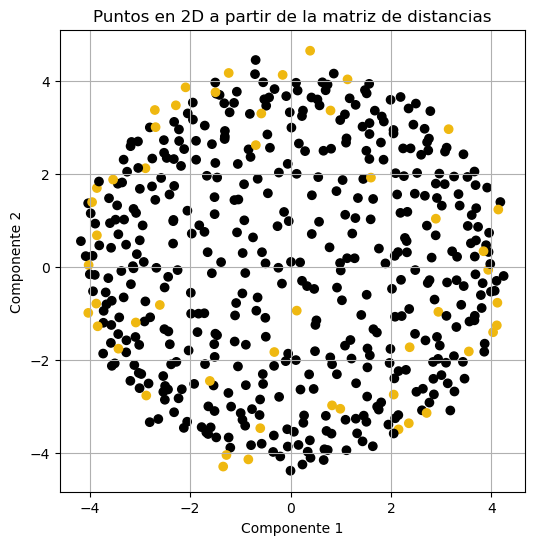

In [2]:
def resolver(path, alpha, tiempo):
    inst = instance.readInstance(path)
    sol, _, _ = grasp.execute(inst, tiempo, alpha)
    solution.printSolution(sol)
    return sol["sol"]

def visualizar_solucion(path, alpha=None, tiempo=1):
    if alpha != None:
        sol = resolver(path, alpha, tiempo)
    else:
        sol = []

    # Cargar el archivo con las distancias
    distancias = pd.read_table(path, sep = " ", skiprows=1, header=None)
    # Creamos la matriz de distancias
    n_nodos = distancias.loc[:,1].max()+1
    matriz_distancias = np.zeros([n_nodos,n_nodos])

    for _ , fila in distancias.iterrows():
        i, j, distancia = fila
        matriz_distancias[int(i),int(j)] = distancia
        matriz_distancias[int(j),int(i)] = distancia

    # Visualizamos su representación en 2D
    mds = MDS(n_components=2, dissimilarity='precomputed', random_state=33)
    coordenadas_2d = mds.fit_transform(matriz_distancias)

    # Etiquetas para los puntos (opcional)
    colores = ["#efb810" if i in sol else "black" for i, (x, y) in enumerate(coordenadas_2d)]

    plt.figure(figsize=(6, 6))
    plt.scatter(coordenadas_2d[:, 0], coordenadas_2d[:, 1], color=colores, marker='o')     

    plt.title("Puntos en 2D a partir de la matriz de distancias")
    plt.xlabel("Componente 1")
    plt.ylabel("Componente 2")
    plt.grid(True)
    plt.show()

visualizar_solucion("instances/MDG-a_9_n500_m50.txt",alpha=0)

## 2. Modelo GRASP

### 2.1. Calibrar $\alpha$

Para determinar el valor de $\alpha$ se ha ejecutado el algoritmo GRASP para todas las instancias variando el tiempo de ejecución y $\alpha$. El objetivo es obtener el mejor valor que se adecúe a distintos contextos de ejecución.

Ejecutando `calibrar_alpha.py` se obtiene los resultados conseguidos para distintos valores de alpha dado un tiempo introducido por el usuario. Los resultados se guardan en la carpeta resultados.

### 2.1.1 1 segundo de tiempo de ejecución

In [3]:
def calibrar_alfa(path):
    data = pd.read_csv(path, sep=";")
    
    # Calcular el máximo y la desviación estándar
    data["Maximo"] = float(0)
    for archivo in data["archivo"].unique():
        data.loc[data["archivo"] == archivo,"Maximo"] = data[data["archivo"] == archivo]["valor"].values.max()
    data["Dev"] = (data["Maximo"] - data["valor"]) / data["Maximo"]
    
    alpha_max = data.loc[:,["alpha","Dev"]].groupby("alpha").mean("Dev").sort_values("Dev").head(1).index[0]

    data["Color"] = ['Maximo' if x[1]["valor"] == x[1]["Maximo"] else "Otros" for x in data.iterrows()]
    data.loc[data["alpha"] == alpha_max, "Color"] = f"$\\alpha$ = {alpha_max}"

    return data, alpha_max

data_1, alpha_max_1 = calibrar_alfa("resultados/resultados_1.0s.csv")

# Seleccionar el mejor alfa
data_1.loc[:,["alpha","Dev"]].groupby("alpha").mean("Dev").sort_values("Dev").head()

,Dev
alpha,
0.05,0.003572
0.15,0.003696
0.10,0.003820
0.00,0.003961
0.20,0.004626


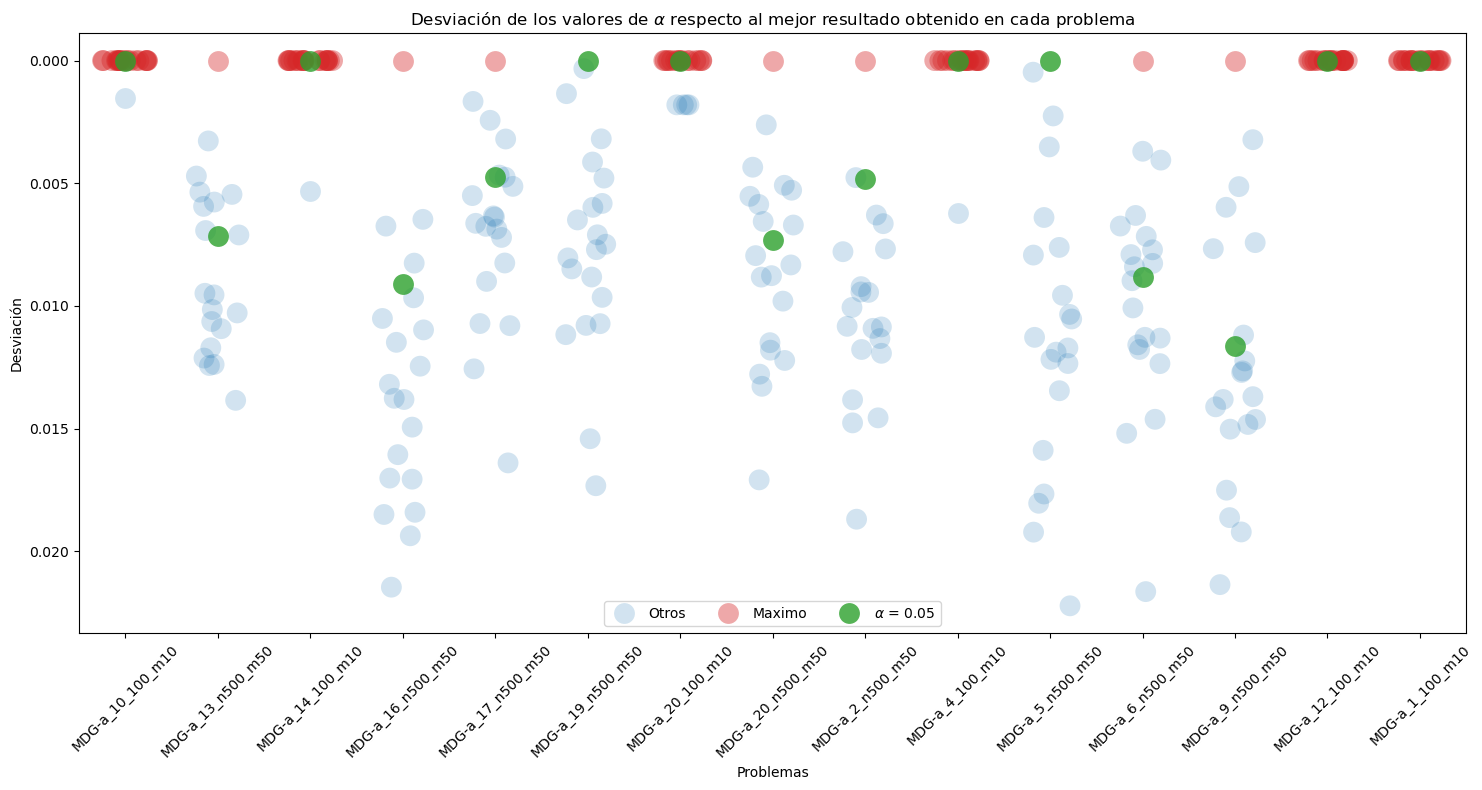

In [4]:
custom_palette = {
    'Otros': '#1f77b4',
    f"$\\alpha$ = {alpha_max_1}": '#2ca02c',
    'Maximo': '#d62728'
}

fig, ax = plt.subplots(figsize=(15,8))
sns.stripplot(data=data_1[data_1["Color"] == "Otros"], x="archivo", y="Dev", hue="Color", alpha=0.2, ax=ax, size=15, jitter=0.25, palette=custom_palette)
sns.stripplot(data=data_1[data_1["Color"] == "Maximo"], x="archivo", y="Dev", hue="Color", alpha=0.4, ax=ax, size=15, jitter=0.25, palette=custom_palette)
sns.stripplot(data=data_1[data_1["Color"] == f"$\\alpha$ = {alpha_max_1}"], x="archivo", y="Dev", hue="Color", alpha=0.8, ax=ax, size=15, jitter=0.25, palette=custom_palette)
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel("Problemas")
ax.set_ylabel("Desviación")
ax.invert_yaxis()
plt.title("Desviación de los valores de $\\alpha$ respecto al mejor resultado obtenido en cada problema")
plt.legend(ncol=3, loc="lower center", bbox_to_anchor=(0.5, 0))
plt.tight_layout()
plt.show()

### 2.1.2 5 segundos de tiempo de ejecución

In [5]:
data_5, alpha_max_5 = calibrar_alfa("resultados/resultados_5.0s.csv")

# Seleccionar el mejor alfa
data_5.loc[:,["alpha","Dev"]].groupby("alpha").mean("Dev").sort_values("Dev").head()

,Dev
alpha,
0.10,0.001653
0.05,0.002375
0.00,0.002507
0.15,0.002597
0.40,0.002935


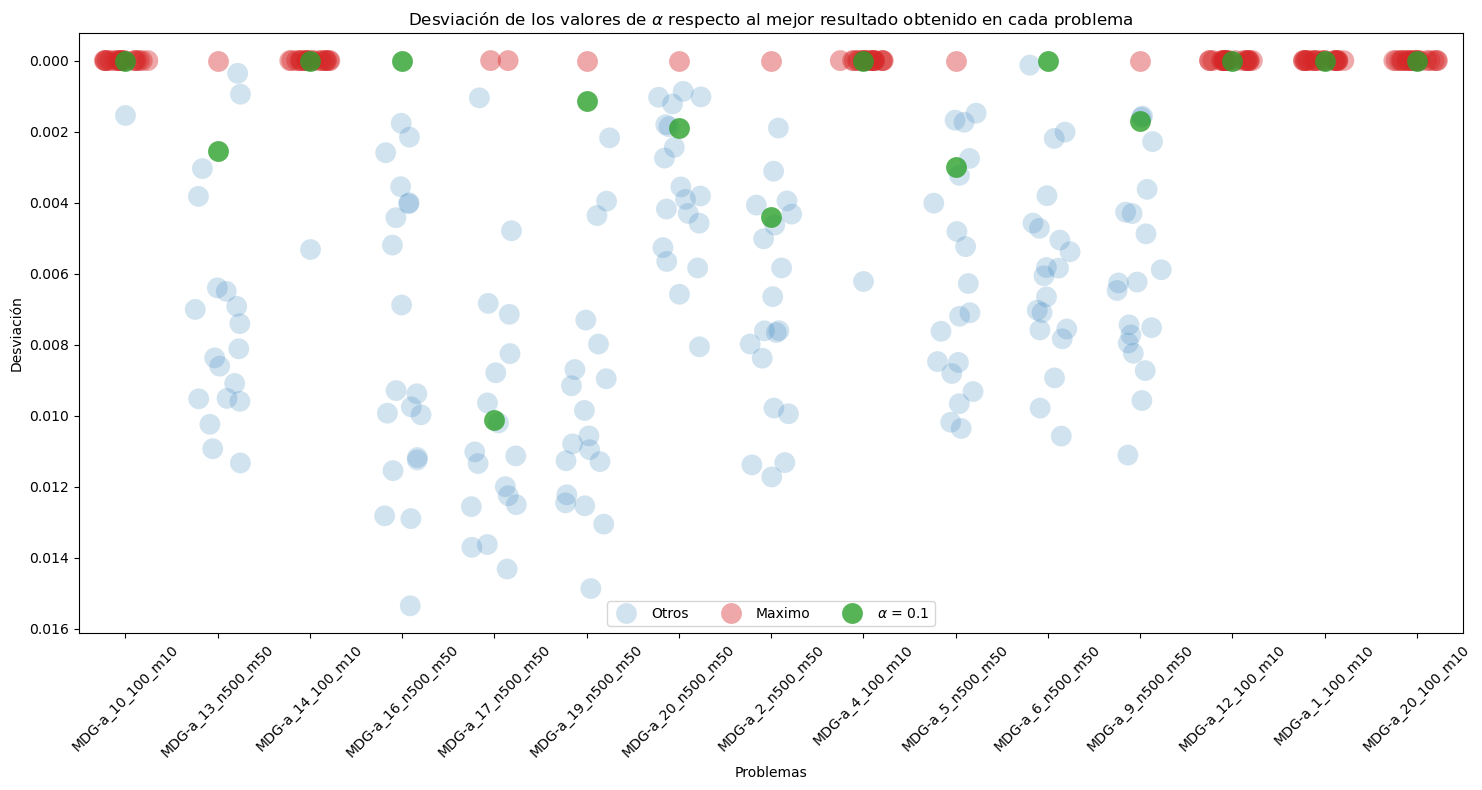

In [6]:
custom_palette = {
    'Otros': '#1f77b4',
    f"$\\alpha$ = {alpha_max_5}": '#2ca02c',
    'Maximo': '#d62728'
}

fig, ax = plt.subplots(figsize=(15,8))
sns.stripplot(data=data_5[data_5["Color"] == "Otros"], x="archivo", y="Dev", hue="Color", alpha=0.2, ax=ax, size=15, jitter=0.25, palette=custom_palette)
sns.stripplot(data=data_5[data_5["Color"] == "Maximo"], x="archivo", y="Dev", hue="Color", alpha=0.4, ax=ax, size=15, jitter=0.25, palette=custom_palette)
sns.stripplot(data=data_5[data_5["Color"] == f"$\\alpha$ = {alpha_max_5}"], x="archivo", y="Dev", hue="Color", alpha=0.8, ax=ax, size=15, jitter=0.25, palette=custom_palette)
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel("Problemas")
ax.set_ylabel("Desviación")
ax.invert_yaxis()
plt.title("Desviación de los valores de $\\alpha$ respecto al mejor resultado obtenido en cada problema")
plt.legend(ncol=3, loc="lower center", bbox_to_anchor=(0.5, 0))
plt.tight_layout()
plt.show()

### 2.1.3 10 segundos de tiempo de ejecución

In [7]:
data_10, alpha_max_10 = calibrar_alfa("resultados/resultados_10.0s.csv")

# Seleccionar el mejor alfa
data_10.loc[:,["alpha","Dev"]].groupby("alpha").mean("Dev").sort_values("Dev").head()

,Dev
alpha,
0.05,0.002668
0.50,0.002839
0.10,0.002919
0.15,0.002924
0.00,0.002976


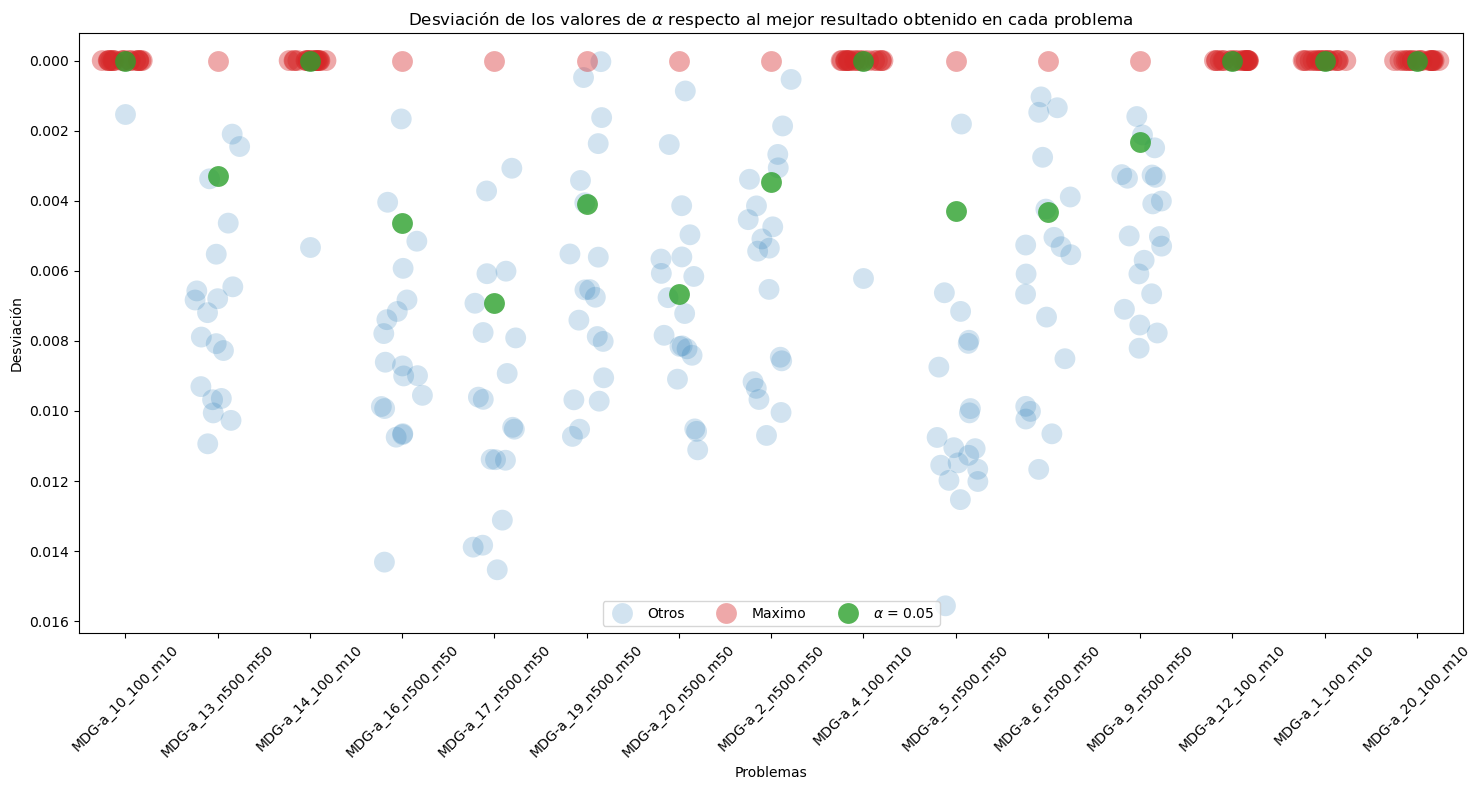

In [8]:
custom_palette = {
    'Otros': '#1f77b4',
    f"$\\alpha$ = {alpha_max_10}": '#2ca02c',
    'Maximo': '#d62728'
}

fig, ax = plt.subplots(figsize=(15,8))
sns.stripplot(data=data_10[data_10["Color"] == "Otros"], x="archivo", y="Dev", hue="Color", alpha=0.2, ax=ax, size=15, jitter=0.25, palette=custom_palette)
sns.stripplot(data=data_10[data_10["Color"] == "Maximo"], x="archivo", y="Dev", hue="Color", alpha=0.4, ax=ax, size=15, jitter=0.25, palette=custom_palette)
sns.stripplot(data=data_10[data_10["Color"] == f"$\\alpha$ = {alpha_max_10}"], x="archivo", y="Dev", hue="Color", alpha=0.8, ax=ax, size=15, jitter=0.25, palette=custom_palette)
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel("Problemas")
ax.set_ylabel("Desviación")
ax.invert_yaxis()
plt.title("Desviación de los valores de $\\alpha$ respecto al mejor resultado obtenido en cada problema")
plt.legend(ncol=3, loc="lower center", bbox_to_anchor=(0.5, 0))
plt.tight_layout()
plt.show()

### 2.1.4 Selección de $\alpha$

In [9]:
data_todos = pd.concat([data_1, data_5, data_10])
data_todos["segundos"] = np.floor(data_todos["tiempo"])
data_todos = data_todos[["alpha","segundos","Dev"]]
data_todos_grouped = data_todos.groupby(["alpha","segundos"]).mean().reset_index()
data_todos_grouped["Dev"] = data_todos_grouped["Dev"] * 100

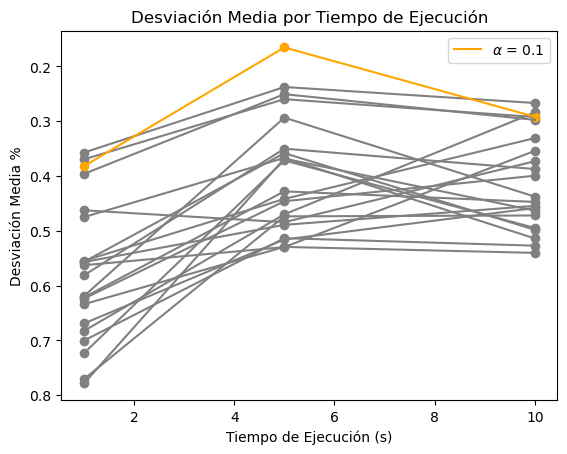

In [10]:
fig, ax = plt.subplots()
for alpha in [i / 100 for i in range(0,101)]:
    if alpha != 0.1:
        ax.plot(data_todos_grouped[data_todos_grouped["alpha"] == alpha]["segundos"], data_todos_grouped[data_todos_grouped["alpha"] == alpha]["Dev"], color = "gray")
        ax.scatter(x = data_todos_grouped[data_todos_grouped["alpha"] == alpha]["segundos"], y = data_todos_grouped[data_todos_grouped["alpha"] == alpha]["Dev"], color = "gray")
ax.plot(data_todos_grouped[data_todos_grouped["alpha"] == 0.1]["segundos"], data_todos_grouped[data_todos_grouped["alpha"] == 0.1]["Dev"], color = "orange", label = "$\\alpha$ = 0.1")
ax.scatter(x = data_todos_grouped[data_todos_grouped["alpha"] == 0.1]["segundos"], y = data_todos_grouped[data_todos_grouped["alpha"] == 0.1]["Dev"], color = "orange")
ax.invert_yaxis()
ax.set_xlabel("Tiempo de Ejecución (s)")
ax.set_ylabel("Desviación Media %")
ax.set_title("Desviación Media por Tiempo de Ejecución")
plt.legend()
plt.show()

A partir de los resultados anteriores, se utilizará $\alpha = 0.1$ como base para la comparativa.

## 3. Path Relinking

Al ejecutar `path_relinking_todas_instancias.py` se guardan en un archivo .csv los resultados obtenidos de cada instancia.

## 4. Resultados

In [11]:
data_1_0_1 = data_1[data_1["alpha"] == 0.1].loc[:,["archivo","alpha","valor","tiempo"]]
data_1_0_1["t_objetivo"] = 1
data_5_0_1 = data_5[data_5["alpha"] == 0.1].loc[:,["archivo","alpha","valor","tiempo"]]
data_5_0_1["t_objetivo"] = 5
data_10_0_1 = data_10[data_10["alpha"] == 0.1].loc[:,["archivo","alpha","valor","tiempo"]]
data_10_0_1["t_objetivo"] = 10
data_60_0_1 = pd.read_csv("resultados/resultados_60.0s.csv", sep=";")
data_60_0_1["t_objetivo"] = 60

data_0_1 = pd.concat([data_1_0_1, data_5_0_1, data_10_0_1, data_60_0_1]).reset_index(drop=True)
data_0_1["Modelo"] = "GRASP"

data_pr_1 = pd.read_csv("resultados/resultados_pr_1.0s.csv", sep=";")
data_pr_1["t_objetivo"] = 1
data_pr_5 = pd.read_csv("resultados/resultados_pr_5.0s.csv", sep=";")
data_pr_5["t_objetivo"] = 5
data_pr_10 = pd.read_csv("resultados/resultados_pr_10.0s.csv", sep=";")
data_pr_10["t_objetivo"] = 10
data_pr_60 = pd.read_csv("resultados/resultados_pr_60.0s.csv", sep=";")
data_pr_60["t_objetivo"] = 60

data_pr = pd.concat([data_pr_1, data_pr_5, data_pr_10, data_pr_60]).reset_index(drop=True)
data_pr["Modelo"] = "GRASP + PR"

data_0_1 = pd.concat([data_0_1, data_pr]).reset_index(drop=True)
data_0_1["valor"] = round(data_0_1["valor"],2)

In [12]:
data_0_1_60 = data_0_1[data_0_1["t_objetivo"] == 60]
data_0_1_60 = data_0_1_60.reset_index(drop=True)

maximos_60 = data_0_1_60.groupby("archivo").max().reset_index().loc[:,["archivo","valor"]]
maximos_60 = maximos_60.rename(columns={"valor":"max"})

data_0_1_60= data_0_1_60.set_index('archivo').join(maximos_60.set_index('archivo')).reset_index()
data_0_1_60["dif"] = (data_0_1_60["max"] - data_0_1_60["valor"]) / data_0_1_60["max"] * 100

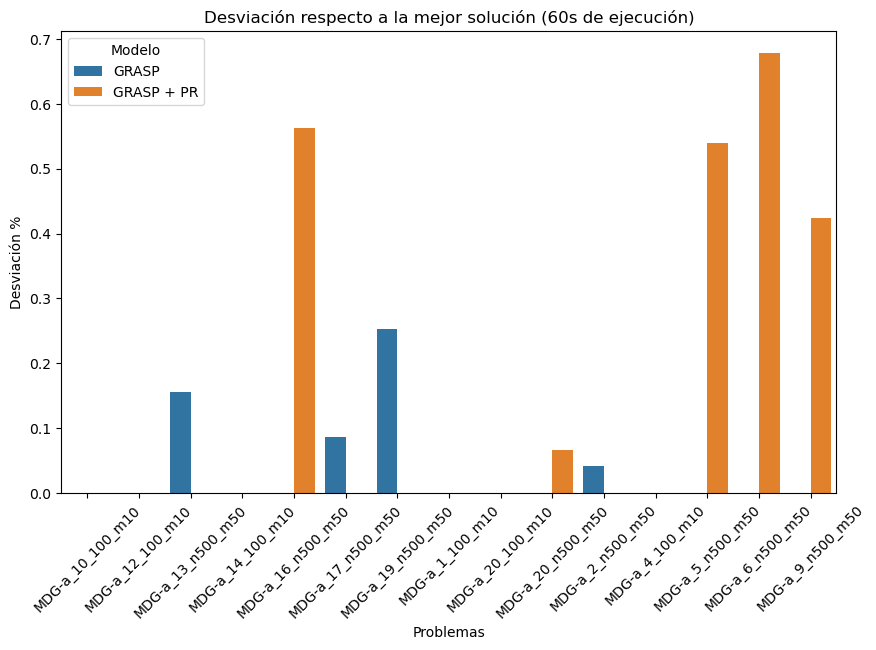

In [13]:
fig, ax = plt.subplots(figsize=(10,6))
sns.barplot(data=data_0_1_60, x='archivo', y='dif', hue='Modelo', ax=ax, errorbar=None)
ax.tick_params(axis='x', rotation=45)
ax.set_title("Desviación respecto a la mejor solución (60s de ejecución)")
ax.set_xlabel("Problemas")
ax.set_ylabel("Desviación %")
plt.show()

In [14]:
maximos = data_0_1.groupby(["archivo","t_objetivo"]).max().loc[:,["valor"]]
maximos = maximos.rename(columns={"valor":"max"})

tabla = data_0_1.set_index(["archivo","t_objetivo"]).join(maximos).reset_index()

tabla["n"] = 500
tabla.loc[tabla["archivo"].str.find("100") > -1,"n"] = 100

tabla["es_maximo"] = tabla["valor"] == tabla["max"]
tabla["dif"] = (tabla["max"] - tabla["valor"]) / tabla["max"]

In [15]:
tabla.groupby(["t_objetivo","n","Modelo"]).sum("es_maximo").loc[:,"es_maximo"]

t_objetivo  n    Modelo    
1           100  GRASP         6
                 GRASP + PR    4
            500  GRASP         8
                 GRASP + PR    1
5           100  GRASP         6
                 GRASP + PR    6
            500  GRASP         8
                 GRASP + PR    1
10          100  GRASP         6
                 GRASP + PR    6
            500  GRASP         6
                 GRASP + PR    3
60          100  GRASP         6
                 GRASP + PR    6
            500  GRASP         5
                 GRASP + PR    4
Name: es_maximo, dtype: int64

In [16]:
tabla.groupby(["t_objetivo","n","Modelo"]).mean("tiempo").loc[:,"tiempo"]

t_objetivo  n    Modelo    
1           100  GRASP          1.000333
                 GRASP + PR     1.037541
            500  GRASP          1.038133
                 GRASP + PR     1.485758
5           100  GRASP          5.000767
                 GRASP + PR     3.657180
            500  GRASP          5.019344
                 GRASP + PR     5.766493
10          100  GRASP         10.001283
                 GRASP + PR     6.175223
            500  GRASP         10.043767
                 GRASP + PR    10.704996
60          100  GRASP         60.000617
                 GRASP + PR    31.832023
            500  GRASP         60.050778
                 GRASP + PR    60.930445
Name: tiempo, dtype: float64

In [17]:
tabla.groupby(["t_objetivo","n","Modelo"]).mean("dif").loc[:,"dif"] * 100

t_objetivo  n    Modelo    
1           100  GRASP         0.000000
                 GRASP + PR    0.118527
            500  GRASP         0.011925
                 GRASP + PR    0.634533
5           100  GRASP         0.000000
                 GRASP + PR    0.000000
            500  GRASP         0.026300
                 GRASP + PR    0.717857
10          100  GRASP         0.000000
                 GRASP + PR    0.000000
            500  GRASP         0.119350
                 GRASP + PR    0.312648
60          100  GRASP         0.000000
                 GRASP + PR    0.000000
            500  GRASP         0.059700
                 GRASP + PR    0.252267
Name: dif, dtype: float64

En la gráfica se observa que para todos los problemas de tamaño 100 ambas implementaciones convergen a la misma solución. Sin embargo, el tiempo medio de ejecución para GRASP+PR es de 30 segundos, lo que indica que realmente sólo destina al Path-relinking 1 segundo.

Por otra parte, en los problemas de tamaño 500, se alcanza un peor comportamiento por parte de GRASP+PR. Esto se puede deber a que el tiempo destinado al Path-relinking es menor del necesario para encontrar mejores soluciones intermedias, o que el conjunto de élite definido no sea realmente el adecuado.


## 5. Conclusiones

Tras comparar ambas implementaciones, se aprecia un mejor rendimiento del algoritmo GRASP. No obstante, con una versión más optimizada del Path-relinking se podría llegar a mejores resultados.

## 6. Bibliografía

Resende, M. G. C., Ribeiro, C. C., Glover, F., & Martí, R. (2010). Scatter search and path-relinking: Fundamentals, advances, and applications. En M. Gendreau & J.-Y. Potvin (Eds.), Handbook of Metaheuristics (pp. 87–107). Springer. https://doi.org/10.1007/978-1-4419-1665-5_4

Universidad de Sevilla. (s.f.). Capítulo 6 [Tesis de grado, Universidad de Sevilla]. https://biblus.us.es/bibing/proyectos/abreproy/70317/fichero/Capitulo+6.pdf